# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats

D = pd.read_csv('movieDataset.csv')

## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1.1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis and Alternative hypothesis, and spell out what they predict in terms of the observed and expected cell counts.

Null-hypothesis: The null-hypothesis would suppose that there is no relation between director gender and film genre. It means that the observed frequencies of film genres directed by different genders will closely match the expected frequencies calculated under the assumption that film genre and gender are independent.

Alternative hypothesis: The alternative hypothesis would suppose that there is a relation between director gender and film genre. Which means the observed frequencies of film genres directed by different genders will deviate significantly from the expected frequencies where genre and gender are independent.

### Question 1.2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [2]:
# Compute the observed frequencies of genre by director gender
observed_frequencies = pd.crosstab(D['genre'], D['dirGender'])

# Calculate marginal totals for genres and genders
genre_totals = observed_frequencies.sum(axis=1)  # Row totals
gender_totals = observed_frequencies.sum(axis=0)  # Column totals
grand_total = D.shape[0]  # Total number of movies

# Calculate expected frequencies
expected_frequencies = observed_frequencies.copy()
for genre in observed_frequencies.index:
    for gender in observed_frequencies.columns:
        expected = (genre_totals[genre] * gender_totals[gender]) / grand_total
        expected_frequencies.at[genre, gender] = expected

expected_frequencies


dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 1.3: Chi-square (10pts)
Create a function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

The function should take a data frame and return the Chi-square value. Make sure that the function performs all the required computations - it should work without you having to run the code from Question #2 first. 

Report the value of this statistic for the real data. 

Extra challenge: Make your code more flexible by not always using ``genre`` and ``dirGender`` to make the crosstab, but by providing the name of the row and column variable as an input (not required for full points).


In [5]:
def chi_square_test(df, row_var, col_var):
    # compute observed frequencies
    observed = pd.crosstab(df[row_var], df[col_var])
    
    # calculate marginal totals and grand total
    row_totals = observed.sum(axis=1)
    col_totals = observed.sum(axis=0)
    grand_total = df.shape[0]
    
    # calculate expected frequencies
    expected = observed.copy().astype(float)
    for row in observed.index:
        for col in observed.columns:
            expected_val = (row_totals[row] * col_totals[col]) / grand_total
            expected.loc[row, col] = expected_val
    
    # calculate the Chi-square statistic
    chi_square = ((observed - expected) ** 2 / expected).sum().sum()
    
    return chi_square

chi_square_value = chi_square_test(D, 'genre', 'dirGender')
chi_square_value


8.552102881235573

### Question 1.4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework (Question 2.2), so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


In [19]:
def shuffle_col(df, col):
    df_copy = df.copy()
    df_copy[col] = np.random.permutation(df_copy[col])
    return df_copy

def randomization_test(df, fn, col, numIter=500, sides=1, bins=30):
    empirical = fn(df)
    simulated= [fn(shuffle_col(df, col)) for _ in range(numIter)]

    plt.hist(simulated, bins=bins)
    plt.axvline(empirical, color='r', linestyle='dashed', linewidth=2)

    return np.mean(simulated >= empirical if sides == 1 else np.abs(simulated) >= np.abs(empirical))

### Question 1.5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

0.068

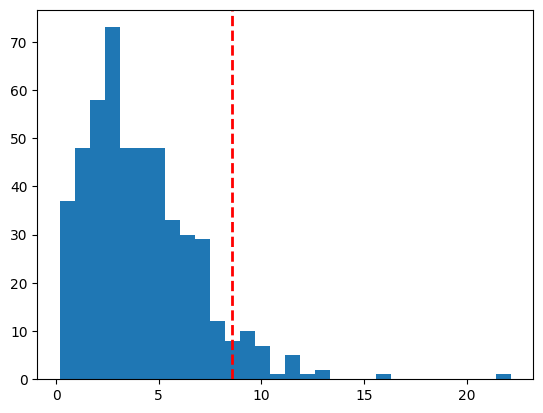

In [20]:
def chi_sq_gender_genre(D):
    return chi_square_test(D, 'genre', 'dirGender')

randomization_test(D, chi_sq_gender_genre, 'genre')

### Question 1.6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

the p-value obtained is 0.068 which is greater than the 0.05 significance level, which means that there isn't sufficient evidence to reject the null hypothesis of independence between genre and gender.

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 2.1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

the null hypothesis would be that there is no statistically significance in annual income between male and female directors, and any observed differenc would be due to random chance. 

### Question 2.2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [18]:
def calculate_income_difference(df):
    male_avg_income = df[df['dirGender'] == 'male']['dirIncome'].mean()
    female_avg_income = df[df['dirGender'] == 'female']['dirIncome'].mean()
    return male_avg_income - female_avg_income

calculate_income_difference(D)

0.6390446473389169

### Question 2.3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test. 

0.0004

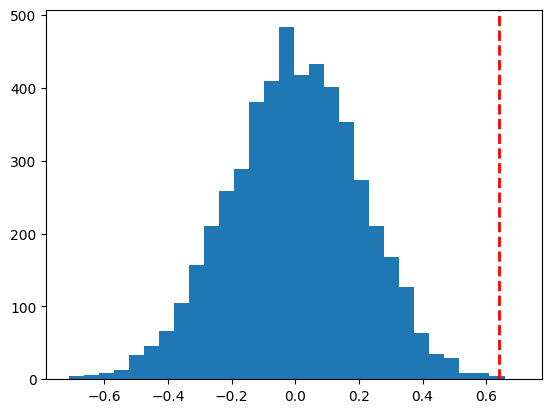

In [32]:
randomization_test(D, calculate_income_difference, 'dirGender', numIter=5000)

### Question 2.4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  


the p-value obtained is nearly 0, suggesting that there is a statistically significant difference between female and male directors incomes. we can conclude that the average male director is paid more than the average female director.

# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).

### Question 3.1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

### Question 3.2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim (Question 1) to simulate 2000 trials of a N coin tosses. 
The function should take as input arguments: 

* `H0prob`: The probability of heads under the Null hypothesis
* `N`: The number of coin throws per trial 
* `numHeads`: The number of observed coin tosses.  

After getting the simulation result from `monteCarloSim`, the function should plot a histogram of the recorded number of heads, and mark the real measured number (`numHeads`) with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads.  

Use the function to evaluate the medical advisor example from the lecture: Determine the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

### Question 3.3: Conclusion (5pts)
Written answer: What do you conclude about the claim that the work of advisor R is lowering complication rates?